## Notebook requirements
- testing has been performed on AWS Jupyterlab using `conda_python3` kernel
- WARNING: additional notes: please review updating `seaborn` in the import section, *if necessary*. [SEABORN UPDATE](#seaborn_upgrade)

- WARNING: please check you are reading the csv from the right location. [FILE IMPORTS](#file_imports)

# Table of Contents

### [Overview](#overview)
- [Introduction](#intro)
- [Project Objective](#objective)
- [Target Feature](#target_feature)

### [Dataset Exploration](#data_exp)
- [Feature Descriptions](#feat_desc)
- [Feature Transformations](#feat_trans)
- [Feature Distributions](#feat_dist)
- [Preliminary Regression Model Testing](#prelim_regresion)
    - [OLS](#p_ols)
    - [RANSAC *w/ MinMax*](#p_ransac)
    - [Ridge *w/ MinMax*](#p_rig)
    - [Lasso *w/ MinMax*](#p_lasso)
    - [Results](#model_var_results)
- [Polynomial Regression Model](#poly_reg)

### [Write out Predictions to CSV](#to_csv)

[Return to top](#top)

<a id='overview'></a>
## Overview

<a id='intro'></a>
### Introduction

The project is the first assessment of the REDACTED course REDACTED Machine Learning, the project is undertaken from a single student, Andrew REDACTED.

<a id='objective'></a>
### Project Objective

The project objective is to predict the life expectancy of a new born based on the given features in the dataset. The major task is to use a **`regression approach`** to predict the life expectancy on test and unseen data.

<a id='target_feature'></a>
### Target Feature

The *given* **target feature** is `LifeExpectancy`: Life Expectancy in age (years)

In [1]:
# importing all modules requried for project

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

<a id='seaborn_upgrade'></a>

In [2]:
# Upgrade of seaborn
# Please be aware that this notebook is intended to work with conda_python3
# you will also need to make sure the latest seaborn is installed

# !pip install seaborn --upgrade

<a id='file_imports'></a>

In [2]:
# Please uncomment your current location


# LOCAL
GHO_FILE = 'dataset/train.csv'

df = pd.read_csv(GHO_FILE, delimiter=',')
df.set_index('ID', inplace=True)

In [3]:
df.head()

,TARGET_LifeExpectancy,Country,Year,Status,AdultMortality,AdultMortality-Male,AdultMortality-Female,InfantDeaths,Alcohol,PercentageExpenditure,...,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,Thinness5-9years,IncomeCompositionOfResources,Schooling
ID,,,,,,,,,,,,,,,,,,,,,
1,67.1,146,2017,0,263,262,264,62,0.01,71.279624,...,6,8.16,65.0,0.1,654.37,33736494,17.2,17.3,0.479,3.178050
2,59.8,146,2016,0,271,278,264,64,0.01,73.523582,...,58,8.18,62.0,0.1,686.22,327582,17.5,17.5,0.476,3.162278
3,57.6,146,2015,0,268,246,290,66,0.01,73.219243,...,62,8.13,64.0,0.1,707.55,31731688,17.7,17.7,0.470,3.146427
4,55.5,146,2014,0,272,248,296,69,0.01,78.184215,...,67,8.52,67.0,0.1,750.35,3696958,17.9,18.0,0.463,3.130495
5,57.7,146,2013,0,275,278,272,71,0.01,7.097109,...,68,7.87,68.0,0.1,71.16,2978599,18.2,18.2,0.454,3.082207


<a id='data_exp'></a>
## Data Exploration

In [5]:
print(f"Size of the dataset {df.shape}\n")

Size of the dataset (2071, 23)



In [6]:
print(f"Dataset Unique Values:\n\n{'Feature':<30}{'Unique Values':>15}\n")
for item in df:
    print(f"{item:<30}{df[item].nunique():>15}")

Dataset Unique Values:

Feature                         Unique Values

TARGET_LifeExpectancy                     424
Country                                   136
Year                                       16
Status                                      2
AdultMortality                            383
AdultMortality-Male                       255
AdultMortality-Female                     255
InfantDeaths                              180
Alcohol                                   915
PercentageExpenditure                    1665
Measles                                   758
BMI                                       557
UnderFiveDeaths                           216
Polio                                      70
TotalExpenditure                          745
Diphtheria                                 78
HIV-AIDS                                  163
GDP                                      1772
Population                               1624
Thinness1-19years                         197
Thinness5

In [7]:
df['Year'].unique()

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003, 2002])

[Return to top](#top)

<a id='feat_desc'></a>
### Feature Descriptions

#### **Categorical Features**
From the above features we can take notice of a few important points

- `Country` is categorical data with an assumed 136 unique countries. Index values have been given to protect the countries identity
- `Year` we can deduce that there are only 16 years of data recorded, pulling out all unique values associated with `Year` we notice that the dataset takes place between *2002 - 2017*
- `Status` has only two unique values, Developed or Developing status (0, 1)

To note that though we are dealing with very few categorical features in this data set it should be known that there is at least seven features within the data set that are percentages or ratings from 0 to 1. This would be a strong case for normalisation.

Text(0.5, 1.0, 'Life Expectancy through out the years')

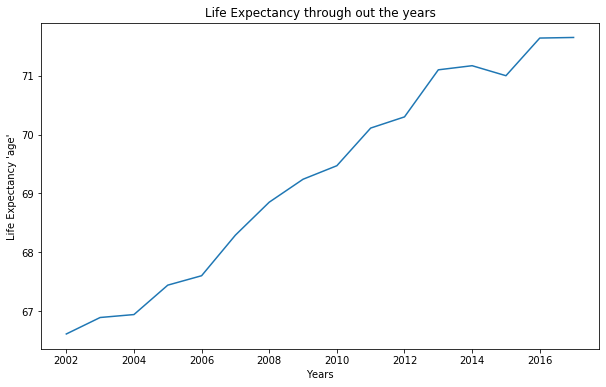

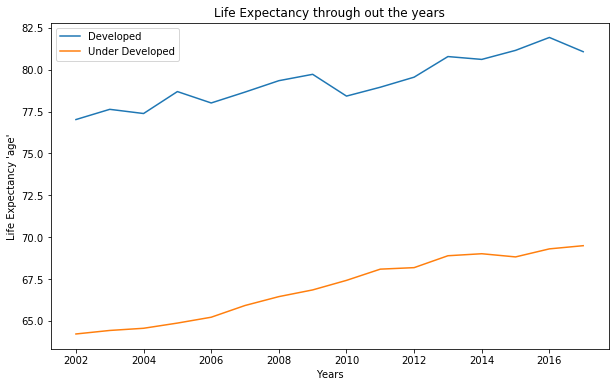

In [8]:
# Creating a structure of all unique 'Years' given in the dataset
year_ds = dict.fromkeys(df['Year'].unique(), None)

# Creating a data structure of all years summed with corresponding life expectancy mean
for key in year_ds.keys():
    year = df[df['Year'] == key]
    year_ds[key] = round(year['TARGET_LifeExpectancy'].mean(), 2)

# Creating data structures of all years summed with corresponding life expectancy mean
# split between developed and not developed countries
undev = df[df['Status'] == 0]
dev = df[df['Status'] == 1]

undev_country = dict.fromkeys(undev['Year'].unique(), None)
dev_country = dict.fromkeys(dev['Year'].unique(), None)

for key in undev_country.keys():
    year = undev[undev['Year'] == key]
    undev_country[key] = round(year['TARGET_LifeExpectancy'].mean(), 2)
    
for key in dev_country.keys():
    year = dev[dev['Year'] == key]
    dev_country[key] = round(year['TARGET_LifeExpectancy'].mean(), 2)
 

plt.figure(figsize=(10,6))
ax = sns.lineplot(list(year_ds.keys()), list(year_ds.values()))
ax.set_xlabel('Years')
ax.set_ylabel("Life Expectancy 'age'")
ax.set_title('Life Expectancy through out the years')

plt.figure(figsize=(10,6))
ax = sns.lineplot(list(dev_country.keys()), list(dev_country.values()), palette = 'blue', label="Developed")
ax = sns.lineplot(list(undev_country.keys()), list(undev_country.values()), palette = 'orange', label="Under Developed")
ax.set_xlabel('Years')
ax.set_ylabel("Life Expectancy 'age'")
ax.set_title('Life Expectancy through out the years')


We can make an assumption here about our data thats been divided into developed countries and non-developed countries. We notice that there is an overall distance of about 10yearr, positive on the side of developments. However we can see a correlation of both under and developed countries increasing in life expectancy over the sixteen yea span.

[Return to top](#top)

### Investigation into correlations of the data

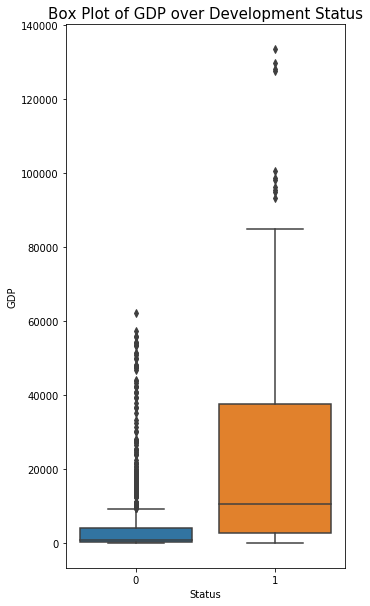

In [9]:
df_gdp = df[(df['Status'] == 1) | (df['Status'] == 0)]

plt.figure(figsize=(5,10))

ax = sns.boxplot(x='Status', y='GDP', data=df_gdp)
ax.set_title('Box Plot of GDP over Development Status', fontsize = 15)

plt.show()

We can take note that there is still large distance between underdevloped countries upper whisker and the developed upper-whisker. While the median of developed is higer than underdeveloped upper whisker

Another important observation here is that given the requirement that `feature selection` **is not allowed** and the importance to outliers here, we may have to look at regularisation but caution to not remove any outliers. 

<Figure size 432x288 with 0 Axes>

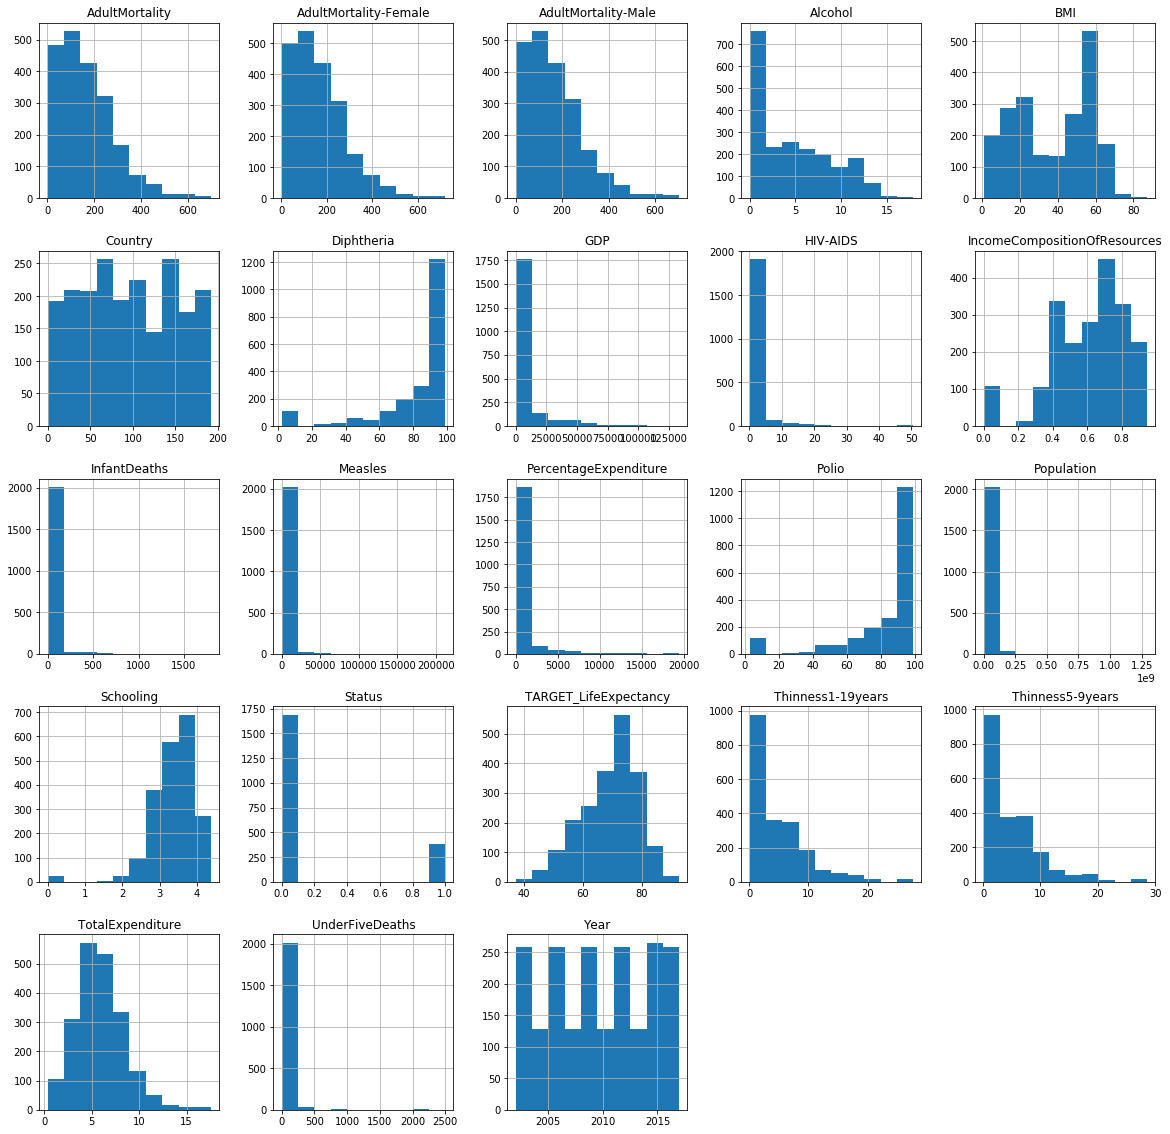

In [10]:
plt.figure()
df.hist(figsize=(20,20)) 
plt.show()

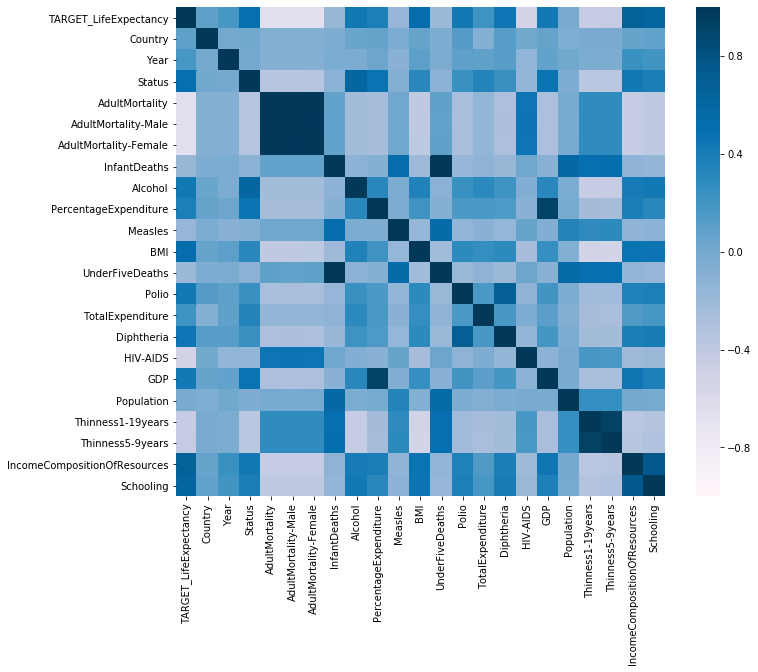

In [11]:
correlations = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, cmap="PuBu", center=0, vmin=-1, vmax=1, square=True)

# fix for mpl bug that cuts off top/bottom of seaborn viz 
b, t = plt.ylim() 

# discover the values for bottom and top 
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values 
plt.show()

After further research into paticular features we notice IncomeCompositionOfResources is actually the Human Development Index (HDI) in terms of income. This is a measurement of life quality that strongly correlates an is part of life expectancy, this possibly could be another strong argument for Lasso as this will effectively weigh our feature towards zero, creating feature selection within the criteria and scope of the assignment

Additionally we notice strong correlations between some features that make this dataset a little more unstable for prediction.

[Return to top](#top)

<a id='feat_trans'></a>
### Feature Transformations
- Unnecessary as the dataset was given clean

In [12]:
# Removing Target_Feature
X = df.drop('TARGET_LifeExpectancy', axis=1) 
Y = df[['TARGET_LifeExpectancy']]

<a id='feat_dist'></a>
## Feature Distributions

Plotting design and representation comes influenced from
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
credit: Jeff Hale
article: Scale, Standardize, or Normalize with Scikit-Learn


In [13]:
from sklearn import preprocessing

In [14]:
#MinMax Scaler
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(X)
df_mm = pd.DataFrame(df_mm)

#Robust Scaler
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(X)
df_r = pd.DataFrame(df_r)

#Standard Scaler
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(X)
df_s = pd.DataFrame(df_s)

#Normaliser
n_scaler = preprocessing.Normalizer()
df_n = n_scaler.fit_transform(X)
df_n = pd.DataFrame(df_n)

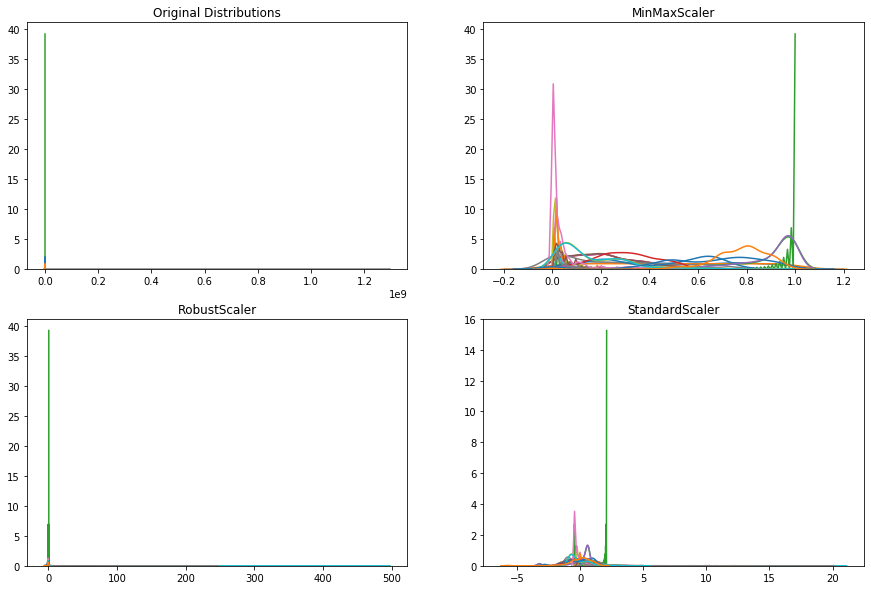

In [15]:
# Combined plot.

fig, ([ax0, ax1], [ax2, ax3]) = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

ax0.set_title('Original Distributions')

for item in X:
    sns.kdeplot(X[item], ax=ax0, legend=False)


ax1.set_title('MinMaxScaler')

for item in df_mm:
    sns.kdeplot(df_mm[item], ax=ax1, legend=False)


ax2.set_title('RobustScaler')

for item in df_r:
    sns.kdeplot(df_r[item], ax=ax2, legend=False)


ax3.set_title('StandardScaler')

for item in df_s:
    sns.kdeplot(df_s[item], ax=ax3, legend=False)

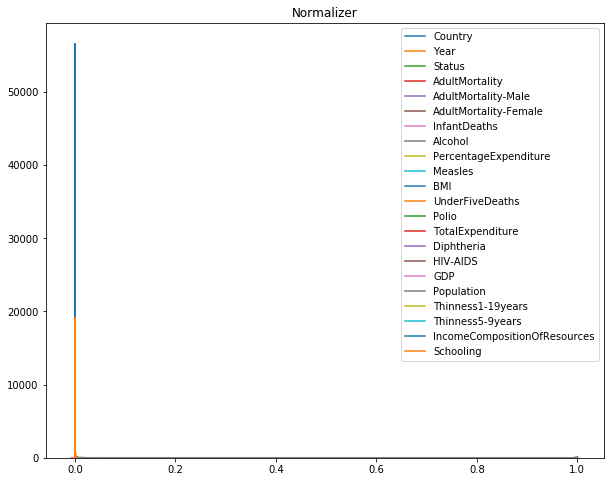

In [16]:
n_scaler = preprocessing.Normalizer()
df_n = n_scaler.fit_transform(X)
col_names = list(X.columns)

df_n = pd.DataFrame(df_n, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Normalizer')

for item in df_n:
    sns.kdeplot(df_n[item], ax=ax1)

**Observations:** looking ahead to the different regression models and scaling/normalising feature values, it would be best to note that MinMax would be the most appropriate course of action.

[Return to top](#top)

<a id='prelim_regresion'></a>    
## Preliminary Regression Model Testing

In [17]:
# Removing Target_Feature
X = df.drop('TARGET_LifeExpectancy', axis=1) 
Y = df[['TARGET_LifeExpectancy']]

In [18]:
#Scaling
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
X_mm = mm_scaler.fit_transform(X)

In [19]:
# create testing and training data for RM variable
# this will be used for all basic testing
from sklearn.model_selection import train_test_split

#Notice given x is the scaled version
trainX, testX, trainY, testY = train_test_split(np.array(X_mm), np.array(Y), test_size=0.2)
ols_trainX, ols_testX, ols_trainY, ols_testY = train_test_split(np.array(X), np.array(Y), test_size=0.2)

In [20]:
from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn import linear_model

In [21]:
#dictionary for all prediction results
results = {'OLS': None, 'RANSAC': None, "Ridge": None, 'Lasso': None}

<a id='p_ols'></a>
## OLS

In [22]:
#OLS regression
#No scaling for benchmark
linReg = linear_model.LinearRegression()
linReg.fit(ols_trainX, ols_trainY)

ols_pred = linReg.predict(ols_testX)
results['OLS'] = ols_pred

Text(0.5, 1.0, 'Residual plot')

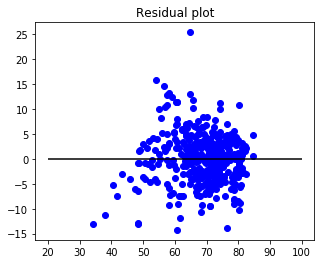

In [23]:
#Interpretation of Regression Plots
plt.figure(figsize=(5,4))
x_plot = plt.scatter(ols_pred, (ols_pred - ols_testY), c='b')

plt.hlines(y=0, xmin= 20, xmax=100)

plt.title('Residual plot')

<a id='p_ransac'></a>
## RANSAC *with MinMax Scaling*

In [24]:
# RANSAC Regression with MinMax
ransacReg = linear_model.RANSACRegressor(min_samples=8, max_trials=100000, random_state=None)
ransacReg.fit(trainX, trainY)

# # Prediction
ransac_pred = ransacReg.predict(testX)
results['RANSAC'] = ransac_pred

In [25]:
print('RANSAC Score: {:.2f}'.format(ransacReg.score(testX, testY)))

RANSAC Score: 0.65


<a id='p_rig'></a>
## Ridge Regression *with MinMax Scaling*

In [26]:
# Ridge Regression with MinMax

alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

ridgeReg = linear_model.RidgeCV(alphas=alphas)
ridgeReg.fit(trainX, trainY)

# # Prediction
ridge_pred = ridgeReg.predict(testX)
results['Ridge'] = ridge_pred

# View alpha
ridgeReg.alpha_

0.001

<a id='p_lasso'></a>
## Lasso Regression *with MinMax Scaling*

In [27]:
# Lasso Regression with MinMax

lassoReg = linear_model.LassoCV(alphas=alphas)
lassoReg.fit(trainX, trainY)

# # Prediction
lasso_pred = lassoReg.predict(testX)
results['Lasso'] = lasso_pred

# View alpha
lassoReg.alpha_

0.0001

<a id='model_var_results'></a>
# Results from model variations

In [28]:
# Evaluation Code
    
for key, item in results.items():
    
    if key == 'OLS':
        y_test = ols_testY 
    else:    
        y_test = testY
    
    # MAE, MSE, RMSE Evaluations 
    print(f"\n{key}  RESULTS")
    print('\nMAE: {:.2}'.format(metrics.mean_absolute_error(y_test, item)))
    print('MSE: {:.2}'.format(metrics.mean_squared_error(y_test, item)))
    print('RMSE: {:.2}'.format(np.sqrt(metrics.mean_squared_error(y_test, item))))
    print('R^2 Score: {:.2}'.format(r2_score(y_test, item)))
    print('-'*80)


OLS  RESULTS

MAE: 3.8
MSE: 2.5e+01
RMSE: 5.0
R^2 Score: 0.75
--------------------------------------------------------------------------------

RANSAC  RESULTS

MAE: 4.0
MSE: 3e+01
RMSE: 5.5
R^2 Score: 0.65
--------------------------------------------------------------------------------

Ridge  RESULTS

MAE: 3.8
MSE: 2.5e+01
RMSE: 5.0
R^2 Score: 0.7
--------------------------------------------------------------------------------

Lasso  RESULTS

MAE: 3.8
MSE: 2.5e+01
RMSE: 5.0
R^2 Score: 0.71
--------------------------------------------------------------------------------


## Observations
Overall performance based on the R^2 score shows OLS, Ridge and Lasso out performing.
However knowing we want to use scaling and wanting to still incorporate our outliers further model tuning will use Lasso

[Return to top](#top)

<a id='poly_reg'></a>
## Polynomial Multiple Regression w/ Lasso Model implementing MinMax
### *Utilising Pipeline*

In [29]:
# create testing and training data for RM variable
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(np.array(X), np.array(Y), test_size=0.2)

In [30]:
#Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
degree = 3

model = Pipeline([('scal', MinMaxScaler()), ('poly', PolynomialFeatures(degree)), ('lasso', LassoCV(alphas=alphas))])
model.fit(trainX, trainY)
pred = model.predict(testX)

In [31]:
# Evaluation Code
print('='*80)
print(f"Polynomial Degree: {degree}")

print('-'*80)
print(f"Best fit Alpha: {model.named_steps['lasso'].alpha_}")

intercept = model.named_steps['lasso'].intercept_
coef = model.named_steps['lasso'].coef_

print("Intercept for the model is {:.4}".format(intercept))
print('-'*80)

for cf in zip(X.columns, coef):
    print("Coefficient::{} is {:.2}".format(cf[0],cf[1]))      
    
# MAE, MSE, RMSE Evaluations 
print('='*80)      
print(f"Result of testing-split data")
print('\nMAE: {:.5}'.format(metrics.mean_absolute_error(testY, pred)))
print('MSE: {:.5}'.format(metrics.mean_squared_error(testY, pred)))
print('RMSE: {:.5}'.format(np.sqrt(metrics.mean_squared_error(testY, pred))))
print('R^2 Score: {:.5}'.format(r2_score( testY, pred)))
print('='*80)

Polynomial Degree: 3
--------------------------------------------------------------------------------
Best fit Alpha: 0.001
Intercept for the model is 44.23
--------------------------------------------------------------------------------
Coefficient::Country is 0.0
Coefficient::Year is 5.8
Coefficient::Status is 4.2
Coefficient::AdultMortality is 1e+01
Coefficient::AdultMortality-Male is 1.9e+01
Coefficient::AdultMortality-Female is 0.0
Coefficient::InfantDeaths is 2.3
Coefficient::Alcohol is -0.0
Coefficient::PercentageExpenditure is 8.2
Coefficient::Measles is 6.7
Coefficient::BMI is 0.0
Coefficient::UnderFiveDeaths is 1.3e+01
Coefficient::Polio is -0.99
Coefficient::TotalExpenditure is 2.8
Coefficient::Diphtheria is -0.0
Coefficient::HIV-AIDS is 2.1
Coefficient::GDP is -5.9e+01
Coefficient::Population is -0.0
Coefficient::Thinness1-19years is 0.0
Coefficient::Thinness5-9years is -0.0
Coefficient::IncomeCompositionOfResources is -8.5
Coefficient::Schooling is 3.5
Result of testing-sp

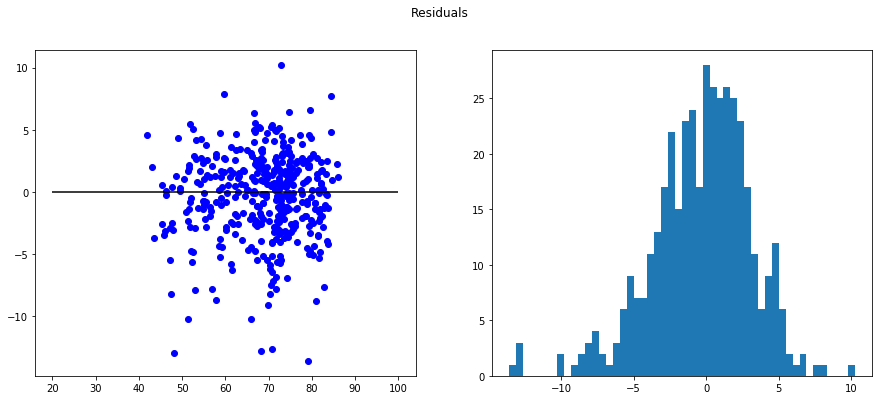

In [32]:

residuals = pred - testY[:,0]
plt.figure(figsize=(15,6))

#Interpretation of Regression Plots

plt.subplot(121)
plt.scatter(pred, (pred - testY[:,0]), c='b')
plt.hlines(y=0, xmin= 20, xmax=100)

plt.subplot(122)
plt.hist(residuals, bins=50)
plt.suptitle('Residuals')
plt.show()

We notice that our largest outliers are where our predictions were too low, as well we notice variance increases as age grows

[Return to top](#top)

<a id='to_csv'></a>
## Write Predictions out to CSV

In [33]:
# to write out predictions please take note that the file writes
# out to a dataset folder, if this does not exist create your file path
 
# please uncomment the function name found in the last line of code to execute

# write out of predictions
def write_out_predictions():
    test_file = 'dataset/test.csv'
    pred_file = './dataset/prediction.csv'

    test = pd.read_csv(test_file, delimiter=',')
    test.set_index('ID', inplace=True)

    prediction = model.predict(test)

    prediction_df = pd.DataFrame(columns=['TARGET_LifeExpectancy'], data=prediction)
    prediction_df.index.rename('ID', inplace=True)
    prediction_df.index += 1
    
    prediction_df.to_csv(pred_file, mode='w', index=True)

# write_out_predictions()